<h1>Diversifying Parameters in Reinforcement Learning</h1>

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
import torch
import matplotlib
#matplotlib.use("Agg")

torch.manual_seed(0)

<h2>Helper Functions</h2>

In [44]:
#!/usr/bin/python
# -*- coding: utf-8 -*-


def step(t):
    return round(t / dt)


def gen_state(ps):
    rand = np.random.random()
    c_ps = np.cumsum(ps)
    return np.argmax(rand < c_ps)


# return learning rate

def alpha_c(bl, delta, c):
    if bl:

      # step function

        if delta > 0:
            return 0
        else:
            return 1
    else:
        return 1 / (1 + math.exp(-c * delta))


def ret_apos(sc, aneg):
    return sc * aneg / (1 - sc)


def compare_floats(float1, float2, error):
    return abs(float1 - float2) <= error


def task_probs(tsk):
    if tsk == 'hyp_unif':
        return [1]
    if tsk == 'hyp_var':
        return [1]
    elif tsk == 'var':
        return [1]
    elif tsk == 'delay':
        return [
            1 / 6,
            1 / 6,
            1 / 6,
            1 / 6,
            1 / 6,
            1 / 6,
            ]


rew = [0, 3]
tt7 = np.arange(1.25, 7, 1.05)

def t_unc(step):
    sd = int(0.2 * unc * step)
    return round(random.uniform(step - sd, step + sd))

def gen_rew(tsk, i):
    if tsk == 'hyp_unif':
        r[i, n, t_unc(step(t_rew[i].item()) - 1)] = s_rew[i, 0]
    if tsk == 'hyp_var':
        r[i, n, t_unc(step(t_rew[i].item()) - 1)] = torch.normal(s_rew[i, 0],
                s_rew[i, 1])
    elif tsk == 'var':
        r[i, n, t_unc(step(t_rew[i].item()) - 1)] = s_rew[gen_state(s_rew[:,
                1]), 0]
    elif tsk == 'delay':
        if i == 4:
            r[i, n, t_unc(step(2.3) - 1)] = torch.tensor(rew[gen_state([0.5,0.5])])
            r[i, n, t_unc(step(5.45) - 1)] = torch.tensor(rew[gen_state([0.5,0.5])])
        elif i == 5:
            for t in tt7:
                r[i, n, t_unc(step(t) - 1)] = torch.tensor(rew[gen_state([5/6, 1/6])])
        else:
            r[i, n, t_unc(step(t_rew[i].item()) - 1)] = s_rew[i]


def valueovertime(diversify=['none']):
    deg_free = len(diversify)
    if deg_free == 1:
        (fig, axs) = plt.subplots(3, 1, figsize=(8, 12))
    elif deg_free == 2:
        (fig, axs) = plt.subplots(3, 3, figsize=(8, 12))
        discrete = set(diversify[1])

    if deg_free == 1:
        lines_V = []
        lines_r = []
        lines_delta = []

        for i in range(n_predictors):
            (line_V, ) = axs[0].plot([], [])
            (line_r, ) = axs[1].plot([], [])
            (line_delta, ) = axs[2].plot([], [])
            lines_V.append(line_V)
            lines_r.append(line_r)
            lines_delta.append(line_delta)

    if deg_free == 2:
        lines_V = [[] for _ in range(len(discrete))]
        lines_r = [[] for _ in range(len(discrete))]
        lines_delta = [[] for _ in range(len(discrete))]

        for i in range(n_predictors):
            for (col_idx, category) in enumerate(discrete):
                (line_V, ) = axs[0, col_idx].plot([], [])
                (line_r, ) = axs[1, col_idx].plot([], [])
                (line_delta, ) = axs[2, col_idx].plot([], [])
                lines_V[col_idx].append(line_V)
                lines_r[col_idx].append(line_r)
                lines_delta[col_idx].append(line_delta)

    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    sm.set_array([])

    def update_plot(frame):
        trial_num = frame - 1

        if deg_free == 1:

            for i in range(n_predictors):
                V_frame = V[i, state, frame, :]
                delta_frame = deltas[i, state, frame, :]
                r_frame = r[state, frame, :]

          # Update lines for each plot

                lines_V[i].set_data(T[:-1], V_frame[:-1])
                lines_r[i].set_data(T[:-1], r_frame[:-1])
                lines_delta[i].set_data(T[:-1], delta_frame)

                if diversify[0] == 'alpha':
                    normalized_value = alphas[i, 0].item() / (alphas[i,
                            0].item() + alphas[i, 1].item())
                    pass
                elif diversify[0] == 'gamma':
                    normalized_value = gammas[i].item()
                    pass
                elif diversify[0] == 'lmbda':
                    normalized_value = lmbdas[i].item()
                    pass
                lines_V[i].set_color(plt.cm.jet(normalized_value))
                lines_r[i].set_color(plt.cm.jet(normalized_value))
                lines_delta[i].set_color(plt.cm.jet(normalized_value))

            axs[0].set_title(f'{state} Trial: {trial_num + 2}')

        elif deg_free == 2:

            for i in range(n_predictors):
                V_frame = V[i, state, frame, :]
                delta_frame = deltas[i, state, frame, :]
                r_frame = r[state, frame, :]

                for (col_idx, category) in enumerate(discrete):

                # if diversify[1] == "alpha":
                #     preds = [(j, predictors[j]) for j in range(len(predictors)) if compare_floats(alphas_sc[j].item(), sc, 0.1)]
                # elif diversify[1] == "gamma":
                #     preds = [(j, predictors[j]) for j in range(len(predictors)) if compare_floats(alphas_sc[j].item(), sc, 0.1)]
                # elif diversify[1] == "lmbda":
                #     preds = [(j, predictors[j]) for j in range(len(predictors)) if compare_floats(alphas_sc[j].item(), sc, 0.1)]

              # Update lines for each plot

                    lines_V[col_idx][i].set_data(T[:-1], V_frame[:-1])
                    lines_r[col_idx][i].set_data(T[:-1], r_frame[:-1])
                    lines_delta[col_idx][i].set_data(T[:-1],
                            delta_frame)

              # Example normalized_value calculation based on diversify[0]

                    if diversify[0] == 'alpha':
                        normalized_value = alphas[i, 0].item() \
                            / (alphas[i, 0].item() + alphas[i,
                               1].item())
                    elif diversify[0] == 'gamma':
                        normalized_value = gammas[i].item()
                    elif diversify[0] == 'lmbda':
                        normalized_value = lmbdas[i].item()

              # Set colors based on normalized_value

                    lines_V[col_idx][i].set_color(plt.cm.jet(normalized_value))
                    lines_r[col_idx][i].set_color(plt.cm.jet(normalized_value))
                    lines_delta[col_idx][i].set_color(plt.cm.jet(normalized_value))

           # Update subplot titles
            axs[0][0].set_title(f'{state} Trial: {trial_num + 2}')

      # Return the updated lines as a list of Artist objects

        return lines_V + lines_r + lines_delta

    animation = FuncAnimation(fig, update_plot, frames=[index
                              for (index, value) in enumerate(states)
                              if value == state], blit=True)  # Fix the frames argument

    if deg_free == 1:
        axs[0].set_ylabel('V(t)')
        axs[0].set_ylim(0, 20)
        axs[0].tick_params(axis='x', rotation=90)

        axs[1].set_ylabel('Reward')
        axs[1].set_ylim(0, 20)
        axs[1].tick_params(axis='x', rotation=90)

        axs[2].set_xlabel('Time (s)')
        axs[2].set_ylabel('TD error')
        axs[2].set_ylim(-20, 20)
        axs[2].tick_params(axis='x', rotation=90)

    if deg_free == 2:
        axs[0, 0].set_ylabel('V(t)')
        axs[1, 0].set_ylabel('Reward')
        axs[2, 0].set_ylabel('TD error')
        axs[2, 0].set_xlabel('Time (s)')
        axs[2, 1].set_xlabel('Time (s)')
        axs[2, 2].set_xlabel('Time (s)')

    plt.setp(axs, xticks=np.arange(0, t_int + dt, dt))

    plt.tight_layout()

    plt.close(animation._fig)
    HTML(animation.to_jshtml())
    if deg_free == 1:
        animation.save(f'animations/{tsk}/{state}/{diversify[0]}.gif', writer=PillowWriter(fps=7))

    elif deg_free == 2:
        animation.save(f'animations/{tsk}/{state}/{diversify[0]}_{diversify[1]}.gif', writer=PillowWriter(fps=7))

def create_valueatstep(
    state,
    step,
    n_steps,
    diversify=['none'],
    ):
    deg_free = len(diversify)

    predictors = []
    tls = [index for (index, value) in enumerate(states) if value
           == state]

    for i in range(n_predictors):
        value = []
        for s in range(n_steps):
            value.append(V[i, state, tls[s], step].item())
        predictors.append(value)

    (fig, ax) = plt.subplots()

    normalized_value = 0
    for i in range(len(predictors)):
        if diversify[0] == 'alpha':
            normalized_value = alphas[i, 0].item() / (alphas[i,
                    0].item() + alphas[i, 1].item())
            pass
        elif diversify[0] == 'gamma':
            normalized_value = gammas[i].item()
            pass
        elif diversify[0] == 'lmbda':
            normalized_value = lmbdas[i].item()
            pass
        plt.plot(predictors[i], color=plt.cm.jet(normalized_value))

  # Create a normalized color map using Normalize class

    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    sm.set_array([])

    cbar = plt.colorbar(sm)
    cbar.set_label('Color Range')

    ax.set_xlabel('Number of trials')
    ax.set_ylabel('Value')

    ax.set_title(f'{diversify} Value of Value Predictors (n={n_predictors}) at Time of Stim, {n_steps} pos Trials')
    ax.set_title(f'TD Error (n={n_predictors}) at Time of Reward, {len(delta_list[0][state])} {state} Trials')

    ax.grid(True)

    plt.legend()
    plt.show()


    plt.savefig(f'figures/{tsk}/{state}/{diversify[0]}.png')

def heatmaps(state, prs, diversify=['none']):
    deg_free = len(diversify)

    tls = [index for (index, value) in enumerate(states) if value
           == state]
    for i in prs:
        td_i = deltas[i, state, tls, :]
        n = td_i.shape[0]

        if deg_free == 2:
            if (diversify[0] == 'alpha' or diversify[1] == 'alpha') \
                and (diversify[0] == 'gamma' or diversify[1] == 'gamma'
                     ):
                alpha_i = alphas[i, 0].item() / (alphas[i, 0].item()
                        + alphas[i, 1].item())

                plt.title(f"i: {i}, n: {n}, sf: {alpha_i:.2f}, gamma: {gammas[i].item():.2f}, lambda: {lmbda}")

                pass
            elif (diversify[0] == 'alpha' or diversify[1] == 'alpha') \
                and (diversify[0] == 'lambda' or diversify[1]
                     == 'lambda'):
                alpha_i = alphas[i, 0].item() / (alphas[i, 0].item()
                        + alphas[i, 1].item())

                plt.title(f"i: {i}, n: {n}, sf: {alpha_i:.2f}, gamma: {gammas[i].item():.2f}, lambda: {lmbda}")

                pass
            elif (diversify[0] == 'lambda' or diversify[1] == 'lambda') \
                and (diversify[0] == 'gamma' or diversify[1] == 'gamma'
                     ):

                plt.title(f"i: {i}, n: {n}, sf: {alpha}, gamma: {gammas[i].item():.2f}, lambda: {lmbdas[i].item():.2f}")

                pass
        elif deg_free == 1:
            if diversify[0] == 'alpha':
                alpha_i = alphas[i, 0].item() / (alphas[i, 0].item()
                        + alphas[i, 1].item())

                plt.title(f"i: {i}, n: {n}, sf: {alpha_i:.2f}, gamma: {gamma}, lambda: {lmbda}")

                pass
            elif diversify[0] == 'gamma':

                plt.title(f"i: {i}, n: {n}, sf: {alpha}, gamma: {gammas[i].item():.2f}, lambda: {lmbda}")

                pass
            elif diversify[0] == 'lmbda':

                plt.title(f"i: {i}, n: {n}, sf: {alpha}, gamma: {gamma}, lambda: {lmbdas[i].item():.2f}")

                pass

        plt.imshow(td_i, cmap='viridis', interpolation='nearest',
                   aspect='auto')
        plt.colorbar()
        plt.xlabel('Step')
        plt.ylabel('Trial')
        plt.show()


def reward(n_trials, r, t_rew):
    """
    Plots the graph of reward over time.

    Parameters:
    T (numpy array): Time vector.
    r (numpy array): Reward vector.
    t_rew (numpy array): Time steps where rewards are recorded.

    Returns:
    None (displays the plot)
    """

    # Get the index of the step where rewards are recorded

    t_rew_step = step(t_rew[0].item()) - 1

    # Get the rewards corresponding to the recorded time steps

    rewards = r[0, :, t_rew_step]

    # Create the plot

    plt.plot(range(n_trials), rewards)
    plt.xlabel('Trials')
    plt.ylabel('Reward')
    plt.title('Reward Over Trials')
    plt.grid(True)
    plt.show()


<h2>Coding Trials</h2>

In [3]:
#Simulations
# n_trials = 150
# t_int = 10 # length of trial
# dt = 1 # timestep size
# tsk = "hyp_var"

# types = 1
# t_stim = torch.full((types,), 2)
# t_rew = torch.full((types,), 6)
# s_rew = torch.tensor([[1, 0.1], [0.5, 0.1], [0, 0.1], [-1, 0.1]])
# n_predictors = 50 # number of value predictors

In [45]:
# #Variable Magnitude Reward Task Simulations

n_trials = 100
t_int = 7 # length of trial
dt = 0.1 # timestep size
tsk = "var"
unc = 1

types = 1
t_stim = torch.full((types,), 2)
t_rew = torch.full((types,), 6)
s_rew = torch.tensor([[0.1, 0.06612594], [0.3, 0.09090909], [1.2, 0.14847358], [2.5, 0.15489467], [5, 0.31159175], [10, 0.150519], [20, 0.07705306]])
n_predictors = 50 # number of value predictors


In [5]:
#Delay Discounted Reward Task Simulations
# n_trials = 1000
# t_int = 8 # length of trial
# dt = 0.25 # timestep size
# tsk = "delay"

# types = 6
# t_stim = torch.full((types,), 1)
# t_rew = torch.tensor([2.25, 3.5, 5, 7.5, 2, 2])
# s_rew = torch.tensor([3, 3, 3, 3, 0.5, (1/6)])
# n_predictors = 50 # number of value predictors


In [46]:
steps = step(t_int) + 1
T = torch.arange(0, t_int + dt, dt)

#stimulus
x = torch.zeros(types, steps, steps)
for i in range(types):
    x[i, step(t_stim[i].item())-1:, step(t_stim[i].item())-1:] = torch.eye(steps - step(t_stim[i].item()) + 1)

#reward
r = torch.zeros(types, n_trials, steps)
for i in range(types):
    for n in range(n_trials):
        gen_rew(tsk, i)


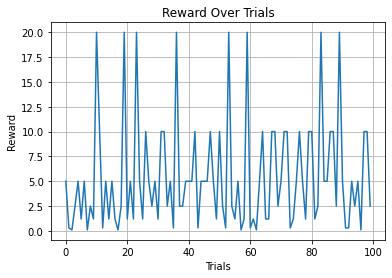

In [5]:
reward(n_trials, r, t_rew)

<h2>Single Parameters</h2>

<h3>Alpha</h3>

In [47]:
#model params
gamma = 0.8   # discount factor
alphas = torch.rand(n_predictors, 2) # learning rate
lmbda = 0.2    # eligibility trace

#################################################################

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbda, dt) * el[i, s, :, t-1] + x[s, :, t]

states = []

# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gamma, dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            rpe_sgn = alpha_c(True, d[t], 0)
            if aoc.item() < 1:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


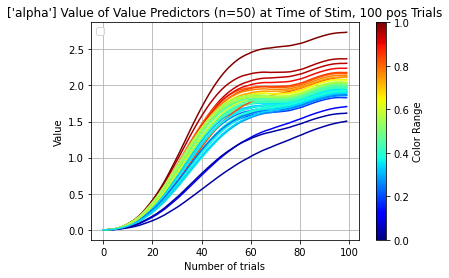

<Figure size 432x288 with 0 Axes>

In [8]:
for st in range(types):
    st = 0
    t = step(t_stim[st].item()) - 1
    stp = 100

    create_valueatstep(st, t, stp, diversify=["alpha"])


In [48]:
state = 0

for state in range(types):
    valueovertime(["alpha"])

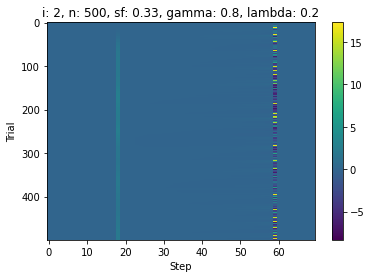

In [11]:
state = 0
prs = range(2,3)

heatmaps(state, prs, diversify=["alpha"])

<h3>Gamma</h3>

In [12]:
#model params 
#gamma = 0.4   discount factor IS DISTRIBUTED BELOW
alpha = 0.5 # learning rate 
lmbda = 0.3 # eligibility trace

####################################################

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)
#alpha step function
gammas = torch.rand(n_predictors, 1)

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbda, dt) * el[i, s, :, t-1] + x[s, :, t]

states = []

# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gammas[i].item(), dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            if aoc.item() < 1:
                dw = (pow(alpha, dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alpha, dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


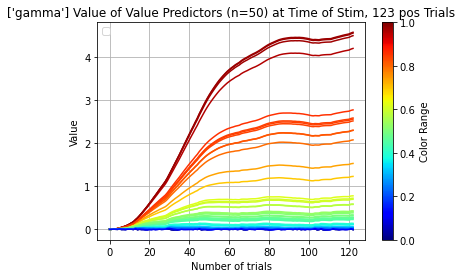

<Figure size 432x288 with 0 Axes>

In [13]:
for st in range(types):
    t = step(t_stim[st].item()) - 1
    stp = 123

    create_valueatstep(st, t, stp, diversify=["gamma"])

In [14]:
state = 0

for state in range(types):
    valueovertime(["gamma"])

Animation size has reached 21027029 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


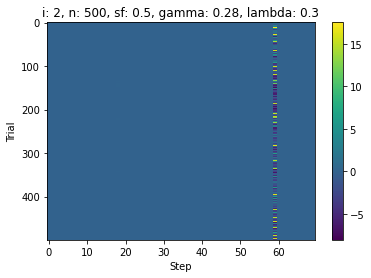

In [15]:
state = 0
prs = range(2,3)

heatmaps(state, prs, diversify=["gamma"])

<h3>Lambda</h3>

In [16]:
#model params 
gamma = 0.7  #discount factor
alpha = 0.1 # learning rate 
lmbdas = torch.rand(n_predictors, 1) #eligibility traces DISTRIBUTED


########################################################

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

#return learning rate
states = []

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbdas[i].item(), dt) * el[i, s, :, t-1] + x[s, :, t]

states = []

# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gamma, dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            if aoc.item() < 1:
                dw = (pow(alpha, dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alpha, dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


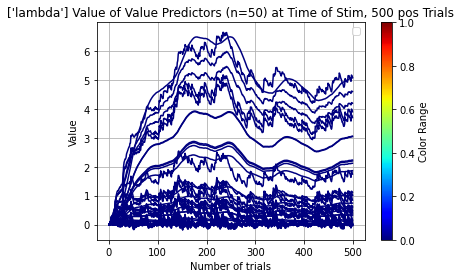

<Figure size 432x288 with 0 Axes>

In [42]:
st = 0
t = step(t_stim[st].item()) - 1
stp = 500

create_valueatstep(st, t, stp, diversify=["lambda"])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


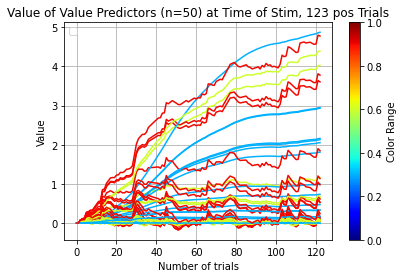

<Figure size 432x288 with 0 Axes>

In [43]:
for st in range(types):
  predictors = []

  tls = [index for index, value in enumerate(states) if value == st]

  for i in range(n_predictors):
    value = []
    for s in range(123):
      value.append(V[i, st, tls[s], step(t_stim[st].item()) - 1].item())
    predictors.append(value)

  fig, ax = plt.subplots()

  for i in range(len(predictors)):
      normalized_value = lmbdas[i].item()
      plt.plot(predictors[i], color=plt.cm.jet(normalized_value))

  # Create a normalized color map using Normalize class
  #norm = plt.Normalize(vmin=0, vmax=1)
  norm = plt.Normalize(vmin=0, vmax=1)
  sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
  sm.set_array([])

  cbar = plt.colorbar(sm)
  cbar.set_label('Color Range')

  ax.set_xlabel('Number of trials')
  ax.set_ylabel('Value')
  ax.set_title(f'Value of Value Predictors (n={n_predictors}) at Time of Stim, {123} pos Trials')
  #ax.set_title(f'TD Error (n={n_predictors}) at Time of Reward, {len(delta_list[0][state])} {state} Trials')
  ax.grid(True)

  plt.legend()
  plt.show()
  plt.savefig(f'figures/{tsk}/{st}/lambda.png')

In [19]:
state = 0

valueovertime(["lmbda"])

Animation size has reached 21018226 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


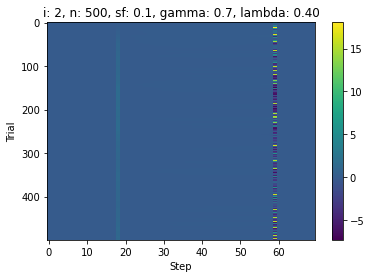

In [20]:
state = 0
prs = range(2,3)

heatmaps(state, prs, diversify=["lmbda"])

<h2>Multiple Parameters</h2>

<h3>Alpha and Gamma</h3>

<h4>Discrete Alpha</h4>

In [9]:
#model params 
gammas = torch.rand(n_predictors, 1) #discount factor 
alphas_sc = torch.tensor([random.choice([0.3, 0.6, 0.9]) for _ in range(n_predictors)])
lmbda = 0.3 # eligibility trace

#################################################


#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)
alphas = torch.rand(n_predictors, 2)
for i in range(alphas.shape[0]):
    alphas[i, 0] = ret_apos(alphas_sc[i].item(), alphas[i, 1].item())
    while alphas[i, 0].item() > 1:
        alphas[i, 1] = random.random()
        alphas[i ,0] = ret_apos(alphas_sc[i].item(), alphas[i, 1].item())

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

#states
states = []

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbda, dt) * el[i, s, :, t-1] + x[s, :, t]


# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gammas[i].item(), dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            rpe_sgn = alpha_c(True, d[t], 0)
            if aoc.item() < 1:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)

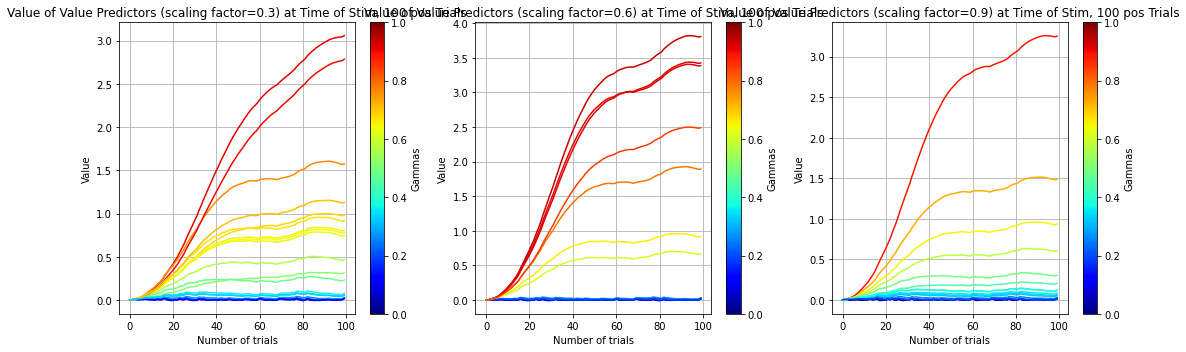

<Figure size 432x288 with 0 Axes>

In [14]:
for st in range(types):
  predictors = []

  tls = [index for index, value in enumerate(states) if value == st]

  for i in range(n_predictors):
    value = []
    for s in range(n_trials):
      value.append(V[i, st, tls[s], step(t_stim[st].item()) - 1].item())
    predictors.append(value)

  # Define the values of scaling factors
  scs = [0.3, 0.6, 0.9]

  # Create subplots for each gamma value
  fig, axs = plt.subplots(1, len(scs), figsize=(15, 5))

  for i, sc in enumerate(scs):
    predictors_sc = []

    # Filter predictors based on the current gamma value
    predictors_sc = [(j, predictors[j]) for j in range(len(predictors)) if compare_floats(alphas_sc[j].item(), sc, 0.1)]

    # Plot the predictors on the corresponding subplot
    axs[i].set_xlabel('Number of trials')
    axs[i].set_ylabel('Value')
    axs[i].set_title(f'Value of Value Predictors (scaling factor={sc}) at Time of Stim, {n_trials} pos Trials')
    axs[i].grid(True)
      
    for j, predictor in enumerate(predictors_sc):
      gm = gammas[predictor[0]].item()
      color = plt.cm.jet(gm)
      axs[i].plot(predictor[1], color=color)

    # Create a colorbar for the current subplot
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axs[i])
    cbar.set_label('Gammas')

  plt.tight_layout()
  plt.show()
  plt.savefig(f'figures/{tsk}/{st}/alphadisc_gamma.png')

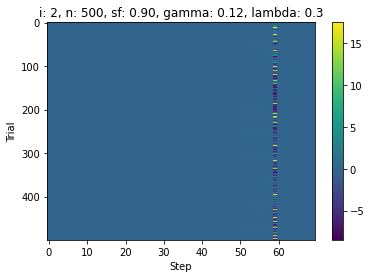

In [23]:
state = 0
prs = range(2,3)

heatmaps(state, prs, diversify=["alpha", "gamma"])

RuntimeError: The animation function must return a sequence of Artist objects.

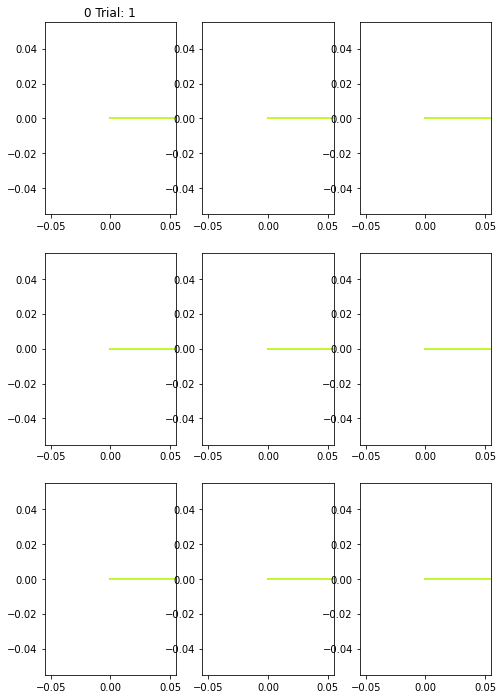

In [38]:
state = 0

for state in range(types):
    valueovertime(diversify = ["alpha", "gamma"])

<h4>Discrete Gamma</h4>

In [24]:
#model params 
gammas = torch.tensor([random.choice([0.3, 0.6, 0.9]) for _ in range(n_predictors)]) #discount factor 
alphas = torch.rand(n_predictors, 2) #learning rate
lmbda = 0.3 # eligibility trace

#################################################

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

#states
states = []

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbda, dt) * el[i, s, :, t-1] + x[s, :, t]


# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gammas[i].item(), dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            rpe_sgn = alpha_c(True, d[t], 0)
            if aoc.item() < 1:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)

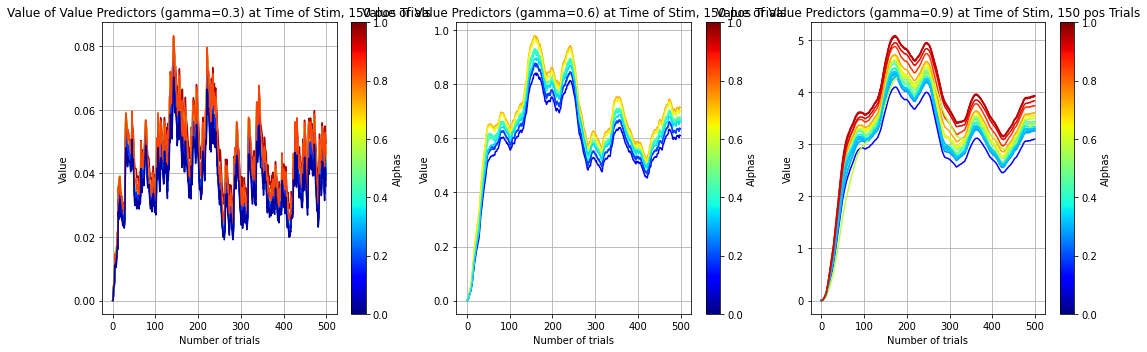

<Figure size 432x288 with 0 Axes>

In [25]:
for st in range(types):
  predictors = []

  tls = [index for index, value in enumerate(states) if value == st]

  for i in range(n_predictors):
    value = []
    for s in range(n_trials):
      value.append(V[i, st, tls[s], step(t_stim[st].item()) - 1].item())
    predictors.append(value)

  # Define the values of gamma
  gms = [0.3, 0.6, 0.9]

  # Create subplots for each gamma value
  fig, axs = plt.subplots(1, len(gms), figsize=(15, 5))

  for i, gamma in enumerate(gms):
    predictors_gamma = []

    # Filter predictors based on the current gamma value
    predictors_gamma = [(j, predictors[j]) for j in range(len(predictors)) if compare_floats(gammas[j].item(), gamma, 0.1)]

    # Plot the predictors on the corresponding subplot
    axs[i].set_xlabel('Number of trials')
    axs[i].set_ylabel('Value')
    axs[i].set_title(f'Value of Value Predictors (gamma={gamma}) at Time of Stim, {150} pos Trials')
    axs[i].grid(True)
      
    for j, predictor in enumerate(predictors_gamma):
      scaling_factor = (alphas[predictor[0], 0].item() / (alphas[predictor[0], 0].item() + alphas[predictor[0], 1].item()))
    # print(f'{predictor[0]} : {scaling_factor}')
      color = plt.cm.jet(scaling_factor)
      axs[i].plot(predictor[1], color=color)

    # Create a colorbar for the current subplot
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axs[i])
    cbar.set_label('Alphas')

  plt.tight_layout()
  plt.show()
  plt.savefig(f'figures/{tsk}/{st}/alpha_gammadisc.png')

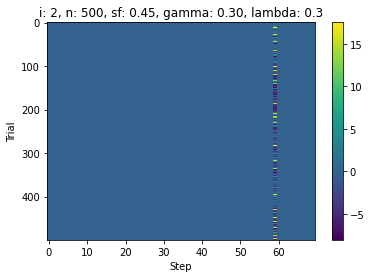

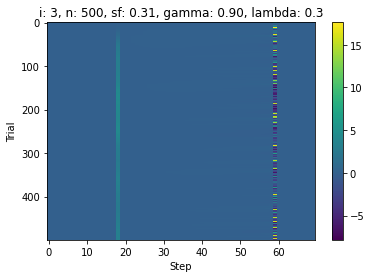

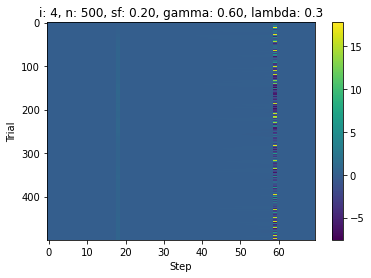

In [26]:
state = 0
prs = range(2,5)

heatmaps(state, prs, diversify=["alpha", "gamma"])

<h3>Alpha and Lambda</h3>

<h4>Discrete Alpha</h4>

In [27]:
#model params 
gamma = 0.7   #discount factor 
alphas_sc = torch.tensor([random.choice([0.2, 0.4, 0.6]) for _ in range(n_predictors)])
lmbdas = torch.rand(n_predictors, 1)

#################################################

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)
alphas = torch.rand(n_predictors, 2)
for i in range(alphas.shape[0]):
    alphas[i, 0] = ret_apos(alphas_sc[i].item(), alphas[i, 1].item())
    while alphas[i, 0].item() > 1:
        alphas[i, 1] = random.random()
        alphas[i ,0] = ret_apos(alphas_sc[i].item(), alphas[i, 1].item())

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

#states
states = []

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbdas[i].item(), dt) * el[i, s, :, t-1] + x[s, :, t]

# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gamma, dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            rpe_sgn = alpha_c(True, d[t], 0)
            if aoc.item() < 1:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)


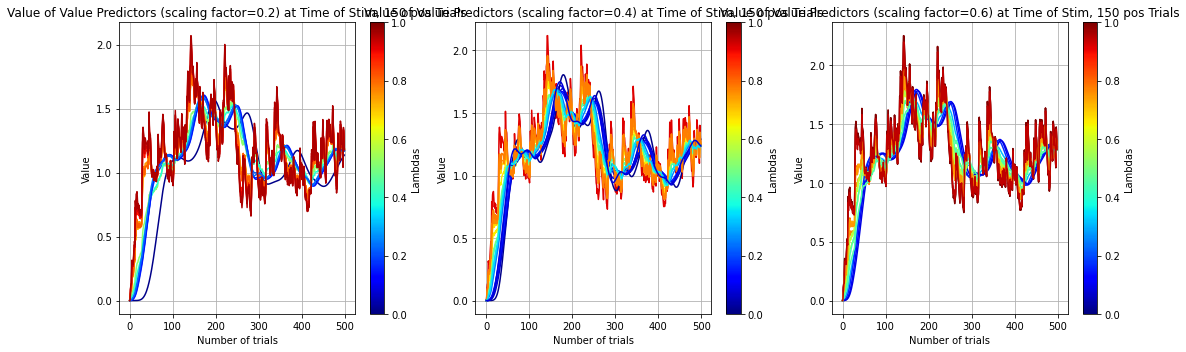

<Figure size 432x288 with 0 Axes>

In [28]:
for st in range(types):
  predictors = []

  tls = [index for index, value in enumerate(states) if value == st]

  for i in range(n_predictors):
    value = []
    for s in range(n_trials):
      value.append(V[i, st, tls[s], step(t_stim[st].item()) - 1].item())
    predictors.append(value)

  # Define the values of scaling factors
  scs = [0.2, 0.4, 0.6]

  # Create subplots for each gamma value
  fig, axs = plt.subplots(1, len(scs), figsize=(15, 5))

  for i, sc in enumerate(scs):
    predictors_sc = []

    # Filter predictors based on the current gamma value
    predictors_sc = [(j, predictors[j]) for j in range(len(predictors)) if compare_floats(alphas_sc[j].item(), sc, 0.1)]

    # Plot the predictors on the corresponding subplot
    axs[i].set_xlabel('Number of trials')
    axs[i].set_ylabel('Value')
    axs[i].set_title(f'Value of Value Predictors (scaling factor={sc}) at Time of Stim, {150} pos Trials')
    axs[i].grid(True)
      
    for j, predictor in enumerate(predictors_sc):
      lm = lmbdas[predictor[0]].item()
      color = plt.cm.jet(lm)
      axs[i].plot(predictor[1], color=color)

    # Create a colorbar for the current subplot
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axs[i])
    cbar.set_label('Lambdas')

  plt.tight_layout()
  plt.show()
  plt.savefig(f'figures/{tsk}/{st}/alphadisc_lambda.png')

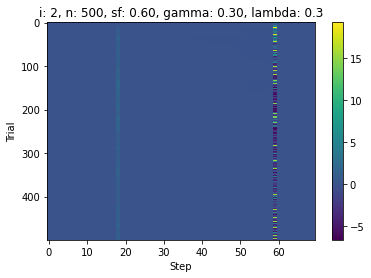

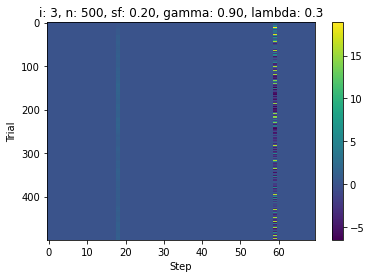

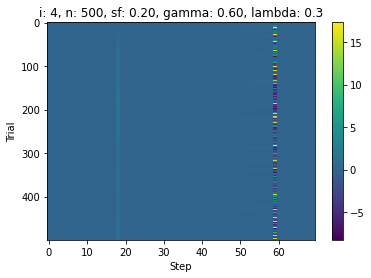

In [29]:
state = 0
prs = range(2,5)

heatmaps(state, prs, diversify=["lambda", "alpha"])

<h4>Discrete Lambda</h4>

In [30]:
#model params 
gamma = 0.4   #discount factor 
alphas = torch.rand(n_predictors, 2)
lmbdas = torch.tensor([random.choice([0.2, 0.4, 0.6]) for _ in range(n_predictors)])

#################################################

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

#states
states = []

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbdas[i].item(), dt) * el[i, s, :, t-1] + x[s, :, t]

# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gamma, dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            rpe_sgn = alpha_c(True, d[t], 0)
            if aoc.item() < 1:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alphas[i, rpe_sgn], dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)


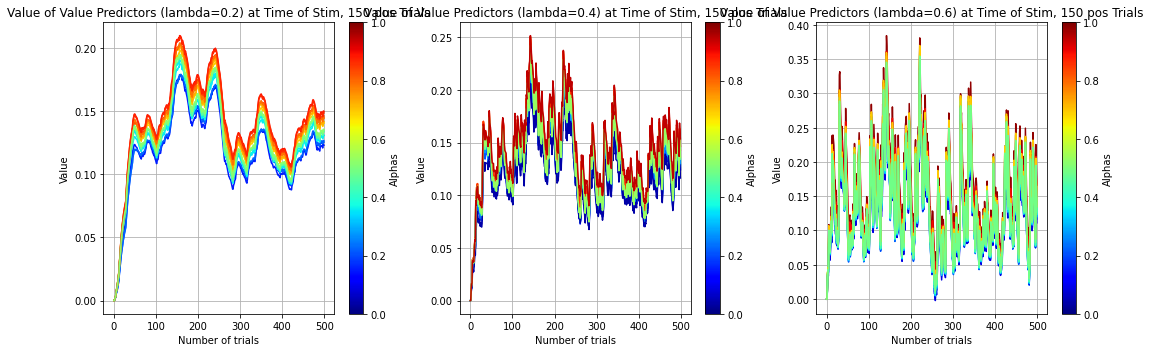

<Figure size 432x288 with 0 Axes>

In [31]:
for st in range(types):
  predictors = []

  tls = [index for index, value in enumerate(states) if value == st]

  for i in range(n_predictors):
    value = []
    for s in range(n_trials):
      value.append(V[i, st, tls[s], step(t_stim[st].item()) - 1].item())
    predictors.append(value)

  # Define the values of gamma
  lams = [0.2, 0.4, 0.6]

  # Create subplots for each gamma value
  fig, axs = plt.subplots(1, len(lams), figsize=(15, 5))

  for i, l in enumerate(lams):
    predictors_lambda = []

    # Filter predictors based on the current gamma value
    predictors_lambda = [(j, predictors[j]) for j in range(len(predictors)) if compare_floats(lmbdas[j].item(), l, 0.1)]

    # Plot the predictors on the corresponding subplot
    axs[i].set_xlabel('Number of trials')
    axs[i].set_ylabel('Value')
    axs[i].set_title(f'Value of Value Predictors (lambda={l}) at Time of Stim, {150} pos Trials')
    axs[i].grid(True)
      
    for j, predictor in enumerate(predictors_lambda):
      scaling_factor = (alphas[predictor[0], 0].item() / (alphas[predictor[0], 0].item() + alphas[predictor[0], 1].item()))
      color = plt.cm.jet(scaling_factor)
      axs[i].plot(predictor[1], color=color)

    # Create a colorbar for the current subplot
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axs[i])
    cbar.set_label('Alphas')

  plt.tight_layout()
  plt.show()
  plt.savefig(f'figures/{tsk}/{st}/alpha_lambdadisc.png')

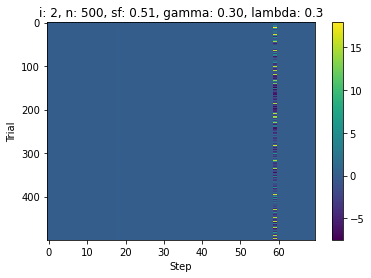

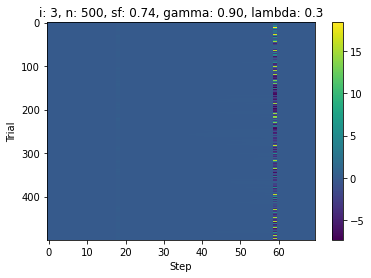

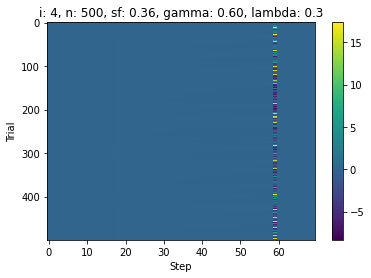

In [32]:
state = 0
prs = range(2,5)

heatmaps(state, prs, diversify=["lambda", "alpha"])

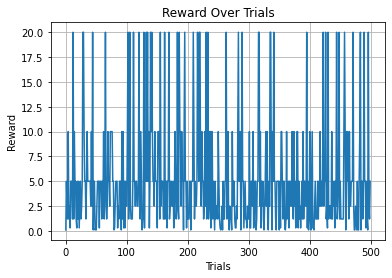

In [33]:
reward(n_trials, r, t_rew)

<h3>Gamma and Lambda</h3>

<h4>Discrete Gamma</h4>

In [34]:
#model params 
gammas = torch.tensor([random.choice([0.3, 0.6, 0.9]) for _ in range(n_predictors)]) #discount factor 
alpha = 0.05 #learning rate
lmbdas = torch.rand(n_predictors, 1) # eligibility trace

#################################################

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

#states
states = []

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbdas[i].item(), dt) * el[i, s, :, t-1] + x[s, :, t]


# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gammas[i].item(), dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            if aoc.item() < 1:
                dw = (pow(alpha, dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alpha, dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)

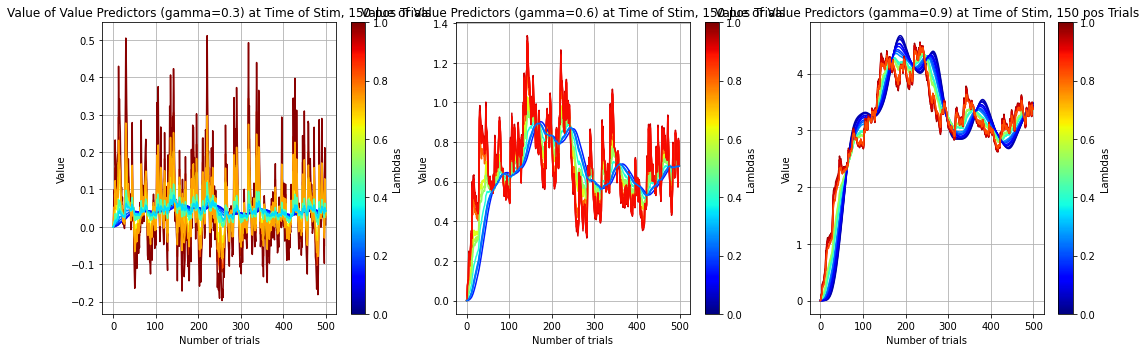

<Figure size 432x288 with 0 Axes>

In [35]:
for st in range(types):
  predictors = []

  tls = [index for index, value in enumerate(states) if value == st]

  for i in range(n_predictors):
    value = []
    for s in range(n_trials):
      value.append(V[i, st, tls[s], step(t_stim[st].item()) - 1].item())
    predictors.append(value)

  # Define the values of scaling factors
  gms = [0.3, 0.6, 0.9]

  # Create subplots for each gamma value
  fig, axs = plt.subplots(1, len(scs), figsize=(15, 5))

  for i, g in enumerate(gms):
    predictors_sc = []

    # Filter predictors based on the current gamma value
    predictors_sc = [(j, predictors[j]) for j in range(len(predictors)) if compare_floats(gammas[j].item(), g, 0.1)]

    # Plot the predictors on the corresponding subplot
    axs[i].set_xlabel('Number of trials')
    axs[i].set_ylabel('Value')
    axs[i].set_title(f'Value of Value Predictors (gamma={g}) at Time of Stim, {150} pos Trials')
    axs[i].grid(True)
      
    for j, predictor in enumerate(predictors_sc):
      lm = lmbdas[predictor[0]].item()
      color = plt.cm.jet(lm)
      axs[i].plot(predictor[1], color=color)

    # Create a colorbar for the current subplot
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axs[i])
    cbar.set_label('Lambdas')

  plt.tight_layout()
  plt.show()
  plt.savefig(f'figures/{tsk}/{st}/gammadisc_lambda.png')

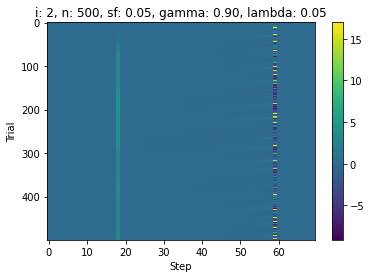

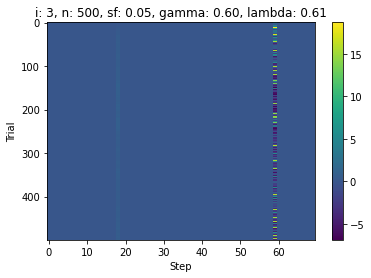

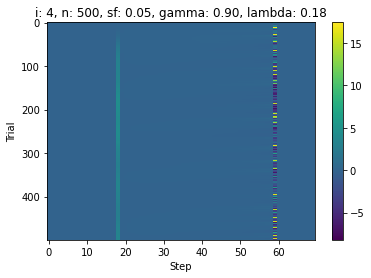

In [36]:
state = 0
prs = range(2,5)

heatmaps(state, prs, diversify=["lambda", "gamma"])

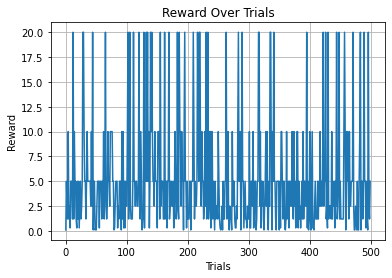

In [37]:
reward(n_trials, r, t_rew)

<h4>Discrete Lambda</h4>

In [38]:
#model params 
gammas = torch.rand(n_predictors, 1) #discount factor 
alpha = 0.05 #learning rate
lmbdas = torch.tensor([random.choice([0.3, 0.6, 0.9]) for _ in range(n_predictors)]) # eligibility trace

#################################################

#weights
w = torch.zeros(n_predictors, types, steps)

#value
V = torch.zeros(n_predictors, types, n_trials, steps)

#deltas
deltas = torch.zeros(n_predictors, types, n_trials, steps - 1)

#states
states = []

el = torch.zeros(n_predictors, types, steps, steps - 1)
for i in range(n_predictors):
    for s in range(types):
        for t in range(steps - 1):
            el[i, s, :, t] = pow(lmbdas[i].item(), dt) * el[i, s, :, t-1] + x[s, :, t]


# beginning of trials
for n in range(n_trials):
    state = gen_state(task_probs(tsk))
    for i in range(n_predictors):
        V[i, state, n, :] = torch.matmul(w[i, state, :], x[state, :, :])
        d = r[state, n, :-1] + (pow(gammas[i].item(), dt) * V[i, state, n, 1:]) - V[i, state, n, :-1]

        for t in range(steps - 1):
            aoc = torch.sum(el[i, state, :, t])
            if aoc.item() < 1:
                dw = (pow(alpha, dt) * d[t]) * el[i, state, :,t]
            else:
                dw = (pow(alpha, dt) * d[t] / aoc.item()) * el[i, state, :,t]
            w[i, state, :] = w[i, state, :] + dw
        
        deltas[i, state, n, :] = d

    states.append(state)

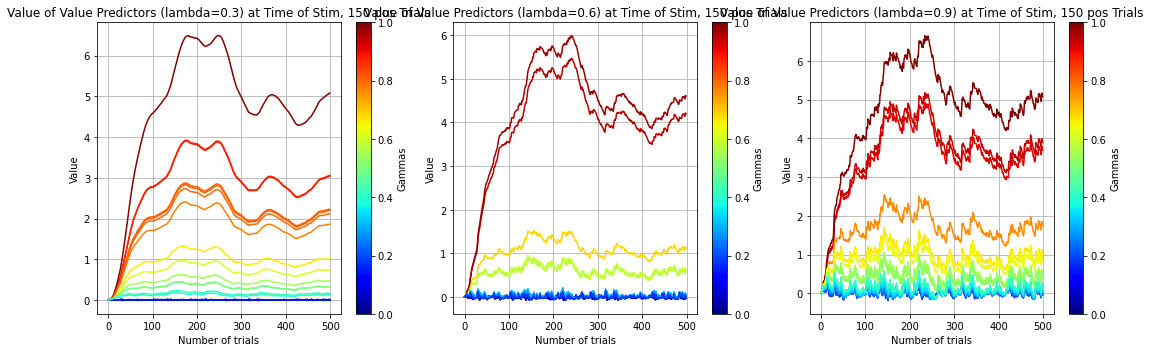

<Figure size 432x288 with 0 Axes>

In [39]:
for st in range(types):
  predictors = []

  tls = [index for index, value in enumerate(states) if value == st]

  for i in range(n_predictors):
    value = []
    for s in range(n_trials):
      value.append(V[i, st, tls[s], step(t_stim[st].item()) - 1].item())
    predictors.append(value)

  # Define the values of scaling factors
  lms = [0.3, 0.6, 0.9]

  # Create subplots for each gamma value
  fig, axs = plt.subplots(1, len(scs), figsize=(15, 5))

  for i, l in enumerate(lms):
    predictors_sc = []

    # Filter predictors based on the current gamma value
    predictors_sc = [(j, predictors[j]) for j in range(len(predictors)) if compare_floats(lmbdas[j].item(), l, 0.1)]

    # Plot the predictors on the corresponding subplot
    axs[i].set_xlabel('Number of trials')
    axs[i].set_ylabel('Value')
    axs[i].set_title(f'Value of Value Predictors (lambda={l}) at Time of Stim, {150} pos Trials')
    axs[i].grid(True)
      
    for j, predictor in enumerate(predictors_sc):
      gm = gammas[predictor[0]].item()
      color = plt.cm.jet(gm)
      axs[i].plot(predictor[1], color=color)

    # Create a colorbar for the current subplot
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axs[i])
    cbar.set_label('Gammas')

  plt.tight_layout()
  plt.show()
  plt.savefig(f'figures/{tsk}/{st}/gamma_lambdadisc.png')

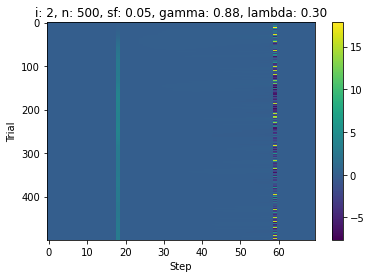

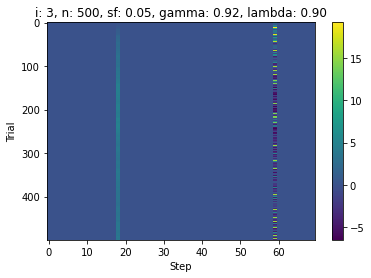

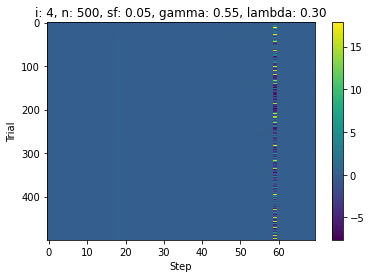

In [40]:
state = 0
prs = range(2,5)

heatmaps(state, prs, diversify=["lambda", "gamma"])

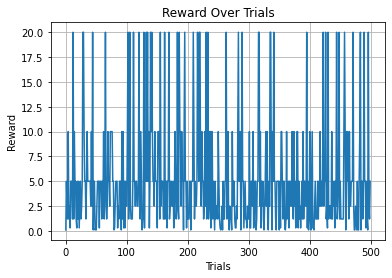

In [41]:
reward(n_trials, r, t_rew)